In [44]:
from shapely.geometry import Point, Polygon, LinearRing, LineString
from shapely.geometry import MultiLineString, MultiPoint, GeometryCollection
from shapely.geos import TopologicalError
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from logging import error
from math import atan

class Rtf:
    """Rotation transform"""
    def __init__(self, angle):
        self.angle = angle
        self.w = np.radians(90 - self.angle)
        self.irm = np.mat([[np.cos(self.w), -np.sin(self.w), 0.0],
                           [np.sin(self.w), np.cos(self.w),  0.0],
                           [0.0,         0.0,          1.0]])
    

class AreaPolygon:
    """Polygon object definition for area coverage path planning"""

    def __init__(self, coordinates, initial_pos, interior=[], ft=1.0, angle=None):
        """Initialization of polygons and transforms"""
        self.P = Polygon(coordinates, interior)

        # Compute path angle
        if angle:
            self.rtf = Rtf(angle) # base on provided angle
        else:
            self.rtf = self.rtf_longest_edge() # based on longest edge of polygon
        self.rP = self.rotated_polygon()    
            
        # Determine origin (i.e. closest vertex to current position)
        self.origin = self.get_furthest_point(self.P.exterior.coords, initial_pos)[0]
        print(self.origin)
        self.ft = ft


    def rtf_longest_edge(self):
        """Computes rotation transform based on longest edge"""

        # Find the longest edge coordinates and angle
        coords = list(self.P.exterior.coords)
        num = len(coords)
        distances = [Point(coords[(num-i)%num]).distance(Point(coords[(num-i-1)%num])) for i in range(num)][::-1]
        max_index = distances.index(max(distances))
        print("Longest edge")
        print(max_index)
        
        dy = float(coords[max_index][1] - coords[max_index + 1][1])
        dx = float(coords[max_index][0] - coords[max_index + 1][0])
        
        return Rtf(np.degrees(np.arctan([dy/dx])))

    def rotate_points(self, points):
        """Applies rtf to polygon coordinates"""
        new_points = []
        for point in points:
            point_mat = np.mat([[point[0]],[point[1]],[0]], dtype='float64')
            new_point = self.rtf.irm * point_mat
            new_points.append(np.array(new_point[:-1].T, dtype='float64'))
        return np.squeeze(np.array(new_points, dtype='float64'))

    def rotate_from(self, points):
        """Rotate an ndarray of given points(x,y) from a given rotation"""
        if type(points) != np.ndarray:
            raise TypeError("rotate_from: takes an numpy.ndarray")
        new_points = []
        for point in points:
            point_mat = np.mat([[point[0]],[point[1]],[0]], dtype='float64')
            new_point = self.rtf.irm.I * point_mat
            new_points.append(np.array(new_point[:-1].T, dtype='float64'))
        return np.squeeze(np.array(new_points, dtype='float64'))

    def rotated_polygon(self):
        """Applies rtf to polygon and holes (if any)"""
        points = np.array(self.P.exterior)
        tf_points = self.rotate_points(points)
        tf_holes = []
        for hole in self.P.interiors:
            tf_holes.append(self.rotate_points(np.array(hole)))
        return self.array2polygon(tf_points, tf_holes)

    def array2polygon(self, points, holes):
        new_exterior = []
        new_interior = []
        
        # Exterior
        for point in points:
            new_exterior.append((float(point[0]),float(point[1])))
            
        # Interior
        for hole in holes:
            new_hole = []
            for p in hole:
                new_hole.append((float(p[0]), float(p[1])))
            new_interior.append(new_hole)
        return Polygon(new_exterior, new_interior)

    def generate_path(self):
        """Generate parallel coverage path lines"""
        starting_breakdown = self.rP.bounds[0:2]  # poly.bounds = bounding box
        line = LineString([starting_breakdown, (starting_breakdown[0],
                                                starting_breakdown[1] +
                                                self.rP.bounds[3] - self.rP.bounds[1])])
        try:
            bounded_line = self.rP.intersection(line)
        except TopologicalError as e:
            error("Problem looking for intersection.", exc_info=1)
            return
        
        lines = [bounded_line]
#         iterations = int(ceil((self.rP.bounds[2] - self.rP.bounds[0]) / ft)) + 1
        iterations = int((self.rP.bounds[2] - self.rP.bounds[0]) / self.ft) + 2
        for x in range(1, iterations):
            bounded_line = line.parallel_offset(x * self.ft, 'right')
            if self.rP.intersects(bounded_line):
                try:
                    bounded_line = self.rP.intersection(bounded_line)
                except TopologicalError as e:
                    error("Problem looking for intersection.", exc_info=1)
                    continue
                lines.append(bounded_line)
        return lines

    def sort_points(self, point, liste):
        "Sorts a set of points by distance to a point"
#         l = deepcopy(liste)
        liste.sort(lambda x, y: cmp(x.distance(Point(*point)),
                                y.distance(Point(*point))))
        return liste

    def get_furthest_point(self, ps, origin):
        "Get a point along a line furthest away from a given point"
        orig_point = Point(*origin)
        return sorted(ps, lambda x, y: cmp(orig_point.distance(Point(*x)),
                                        orig_point.distance(Point(*y))))


    def order_points(self, lines, initial_origin):
        "Return a list of points in a given coverage path order"
        origin = initial_origin
        results = []
        while True:
            if not len(lines):
                break
#             lines = self.sort_points(origin, lines)
            self.sort_points(origin, lines)
            f = lines.pop(0)
            if type(f) == GeometryCollection:
                continue
            if type(f) == MultiLineString:
                for ln in f:
                    lines.append(ln)
                continue
            if type(f) == Point or type(f) == MultiPoint:
                continue
            xs, ys = f.xy
            ps = zip(xs, ys)
            (start, end) = self.get_furthest_point(ps, origin) # determine direction of path (which of the 2 coordinates is closest to the previous endpoint)
            l = LineString([origin, start])
            for hole in self.rP.interiors:
                if type(hole.intersection(l)) == LineString:
                    print("Invalid")
                    print(LineString([origin, start]))
            results.append(origin)
            # results.append(start)
            results.append(start)
            # results.append(end)
            origin = end
        return results

    # NOTE: the decomposition of the area will depend on the robot's footprint
    def boustrophedon_decomposition(self, origin):
        """Decompose polygon area according to Boustrophedon area path planning algorithm"""
        p = self.generate_path()
        return self.order_points(p, origin)

    def get_area_coverage(self, origin=None):
        if origin:
            origin = self.rotate_points(np.array([origin])).tolist()
        else:
            origin = self.rotate_points(np.array([self.origin])).tolist()
        result = self.boustrophedon_decomposition(origin)
        tf_result = self.rotate_from(np.array(result))
        return LineString(tf_result)


def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, 'o', color='#999999', zorder=1)
    
def plot_bounds(ax, ob):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color='#000000', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)


Longest edge
0
(0.0, 8.0)
45.0
Invalid
LINESTRING (-5.45685424949238 1.454213562373095, -5.256854249492379 1.494213562373095)
Invalid
LINESTRING (-3.05685424949238 1.934213562373095, -2.856854249492379 1.974213562373095)
Invalid
LINESTRING (-1.056854249492379 3.185786437626906, -0.856854249492379 3.385786437626906)


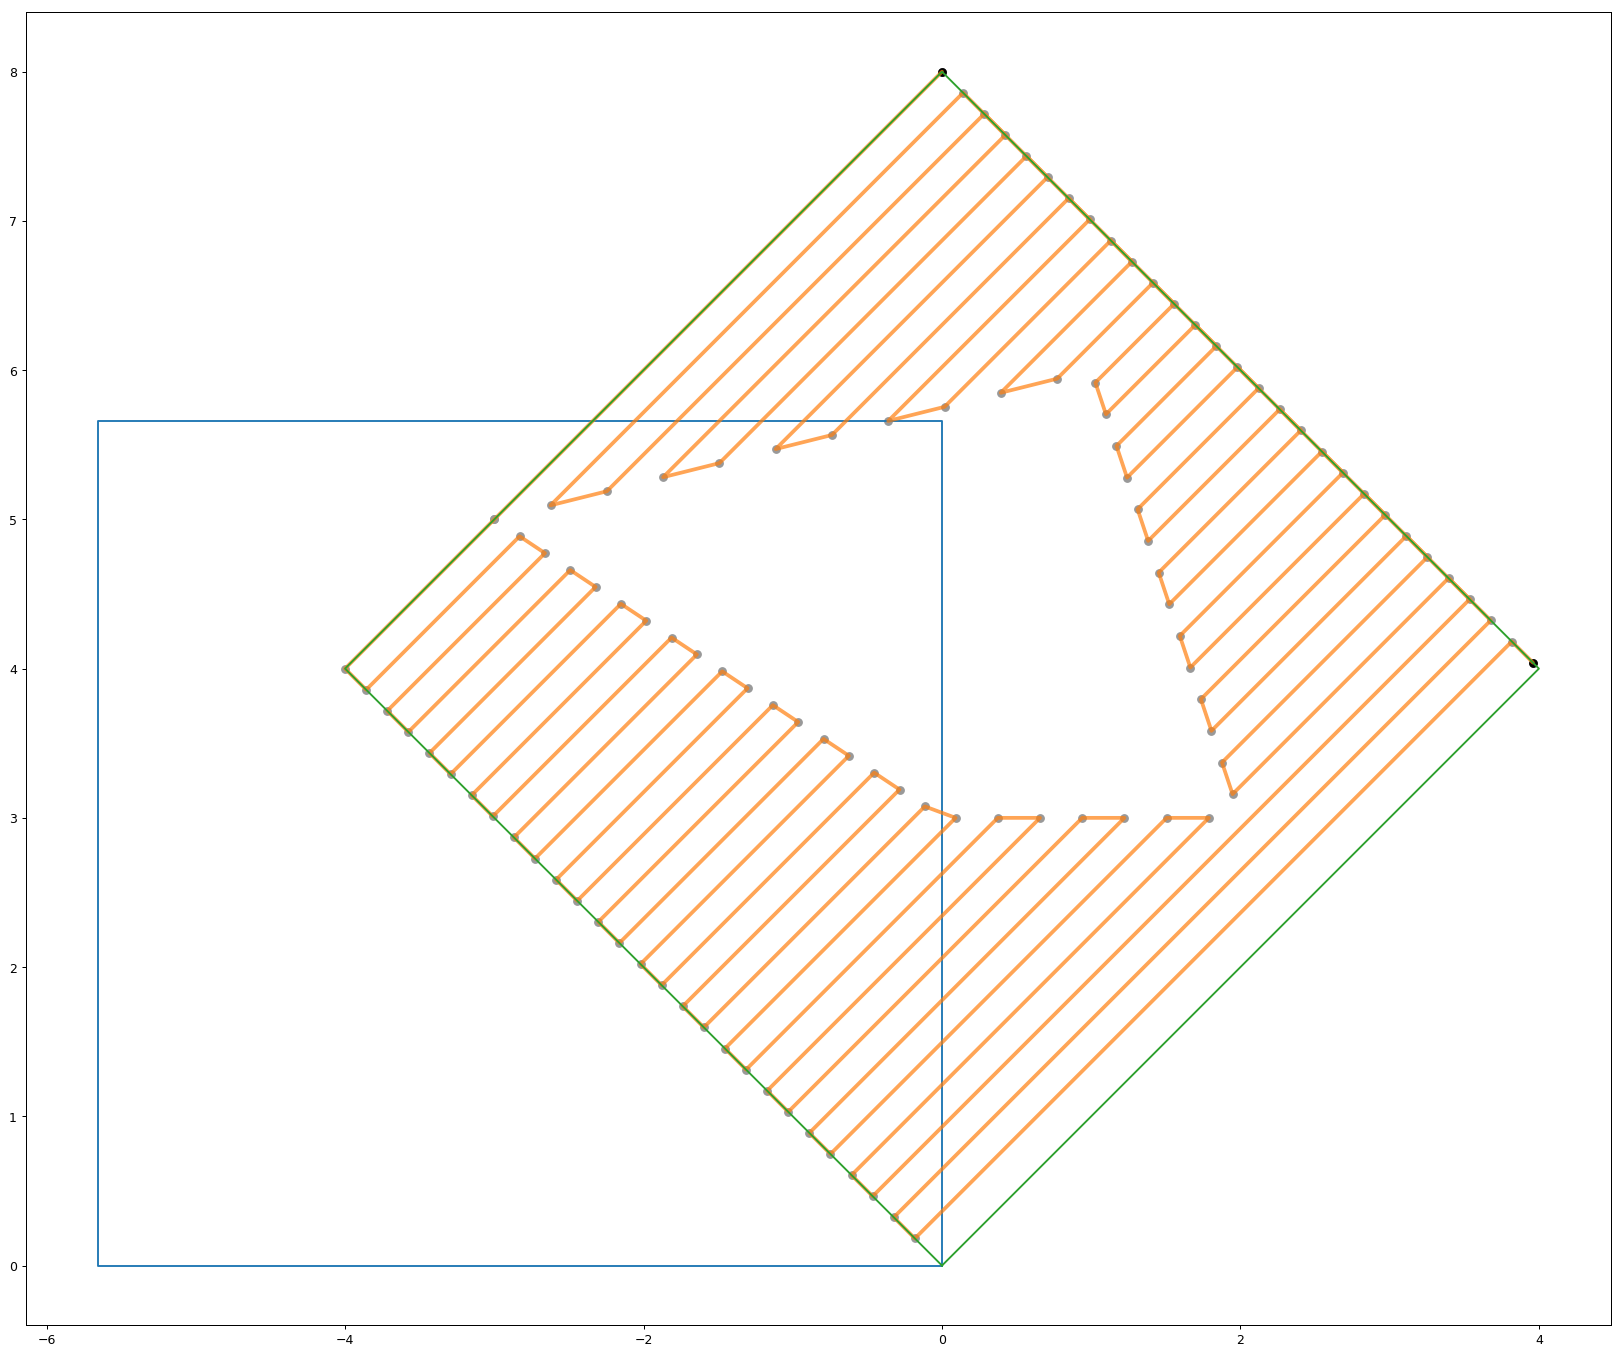

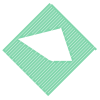

In [50]:
##### Tests #####
# exterior is a LinearRing object, and interiors is a list of zero or more LinearRing objects
# Any LinearRing object will have coords, which you can slice to see a list of the coordinates with coords[:]
if __name__ == '__main__':
    ext = [(0, 0), (4, 4), (0, 8), (-4, 4)]
    holes = [[(0, 3), (2, 3), (1, 6), (-3, 5)]]
    polygon = AreaPolygon(ext, (-5, 10), interior=holes, ft=0.2)
    print(polygon.rtf.angle)
    ll = polygon.get_area_coverage()
    
    # Plotting results
    fig = plt.figure(1, dpi=90)
    ax = fig.add_subplot(121)
    plt.plot(*polygon.rP.exterior.xy)
    plot_coords(ax, ll)
    plot_bounds(ax, ll)
    plot_line(ax, ll)
    plt.plot(*polygon.P.exterior.xy)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.rcParams['figure.figsize'] = [50, 50]
    plt.show()
list(ll.coords)
ll